In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/img_align_celeba.zip -d /content
!cp /content/drive/MyDrive/celeba_list_landmarks_align.txt /content
!cp /content/drive/MyDrive/celeba_identity.txt /content
!mkdir aligned_faces

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NCLASSES = 10177
MAX_CLASSES = 100
VAL_PER_CLASS = 5

In [4]:
#здесь подготовим трейн и вал списки изображений
#берем только топ N классов
import pandas as pd
from sklearn.utils import shuffle
drive = '/content/drive/MyDrive'
df_identity = pd.read_csv(f'{drive}/celeba_identity.txt', header=None, names=['id', 'cls'], sep='\s+')
df_landmarks = pd.read_csv(f'{drive}/celeba_list_landmarks_align.txt', header=1, sep='\s+')
image_dir = '/content/img_align_celeba/'
print(df_identity['cls'].min(),df_identity['cls'].max())

cls_counts = df_identity['cls'].value_counts()
top_classes = cls_counts.head(MAX_CLASSES).index


class_mapping = {old: new for new, old in enumerate(top_classes)}

train_annotations = []
val_annotations = []

for orig_cls in top_classes:
    # Найдём все строки с этим классом
    samples = df_identity[df_identity['cls'] == orig_cls]

    # Перемешаем, чтобы выбор был случайным
    samples = shuffle(samples, random_state=42)

    # Возьмём нужное количество
    l = samples.shape[0]

    train_samples = samples.iloc[ :l - VAL_PER_CLASS]
    val_samples = samples.iloc[l - VAL_PER_CLASS:]

    # Перемапим в новые классы
    new_cls = class_mapping[orig_cls]

    train_annotations.extend([
        (row['id'], new_cls) for _, row in train_samples.iterrows()
    ])

    val_annotations.extend([
        (row['id'], new_cls) for _, row in val_samples.iterrows()
    ])

print("Total train images:", len(train_annotations))
print("Total val images:", len(val_annotations))



1 10177
Total train images: 2538
Total val images: 500


In [ ]:
print(top_classes, cls_counts[3028])
print(train_annotations[25657])
print(df_landmarks.loc['000001.jpg'].values.reshape(-1, 2))

Index([3782, 3227, 2820, 3745, 3699, 8968, 9152, 9256, 4978, 4126,
       ...
       3432, 5157, 1346, 6059, 1467, 2236, 6036, 7003, 6532, 3028],
      dtype='int64', name='cls', length=2000) 30
('148722.jpg', 950)
[[ 69 109]
 [106 113]
 [ 77 142]
 [ 73 152]
 [108 154]]


In [7]:
#далее предподготовка изображений
#проходим по спискам кропаем до квадрата при желании применяем афинные преобразования

import cv2
import numpy as np
from PIL import Image
import os

def center_crop_to_square(img, landmarks):
    h, w = img.shape[:2]
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    cropped = img[top:top + min_dim, left:left + min_dim]
    shifted_landmarks = landmarks - np.array([left, top])

    return cropped, shifted_landmarks

target_dir = "aligned_faces"

dst_size = (224,224)

dst = np.array([
    [40.2946, 54.6963],   # левый глаз
    [71.5318, 54.5014],   # правый глаз
    [56.0252, 71.7366],   # нос
    [41.5493, 88.3655],   # левый рот
    [70.7299, 88.2041]    # правый рот
])

limit = 0

def align_images(annotations, use_affine = True):
    progress = 0
    for a in annotations:
        img_name = a[0]
        coords = df_landmarks.loc[img_name].values.reshape(-1, 2)
        img_path = f"img_align_celeba/{img_name}"
        image = Image.open(img_path)

        image_np = np.array(image)
        image_np, coords = center_crop_to_square(image_np, coords)
        img_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

        if use_affine:
            M = cv2.estimateAffinePartial2D(coords, dst * 2, method=cv2.LMEDS)[0]
            aligned_img = cv2.warpAffine(img_bgr, M, dst_size)
        else:
            aligned_img = img_bgr

        cv2.imwrite(f"{target_dir}/{img_name}", aligned_img)

        progress += 1
        if progress % 10000 == 0: print(f"Processed {progress} images")
    print(f"Done, processed {progress} total images")

align_images(train_annotations, use_affine=False)
align_images(val_annotations, use_affine=False)


Done, processed 2538 total images
Done, processed 500 total images


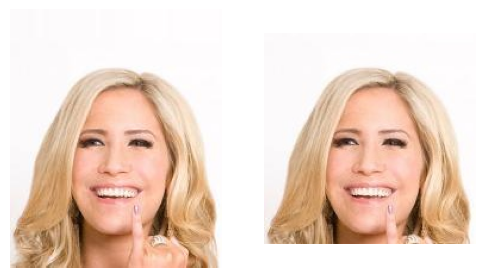

In [112]:
#проверим изображение до и после предподотовки, важно убедиться все сделано корректно
import matplotlib.pyplot as plt

id = train_annotations[2][0]

img1 = Image.open(f"img_align_celeba/{id}")
img2 = Image.open(f"aligned_faces/{id}")


fig, axs = plt.subplots(1, 2, figsize=(6,10))
axs[0].imshow(img1)
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].axis('off')
plt.show()

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import os

class AlignedFaceDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        """
        image_dir: путь к папке с выровненными картинками
        annotations: список (имя файла, метка)
        transform: torchvision.transforms
        """
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename, label = self.annotations[idx]
        img_path = os.path.join(self.image_dir, filename)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(label))

        return image, label

In [10]:
from torch.utils.data import random_split

train_data = AlignedFaceDataset("aligned_faces", train_annotations, transform)
val_data = AlignedFaceDataset("aligned_faces", val_annotations, transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle= True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64)

Для удобства добавил сразу в модель слой эмбеддингов. Дополнительно сделал опцию фриза слоев

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddedBackbone(nn.Module):
    def __init__(self, backbone, num_classes, num_unfreeze = -1, emb_dim = 512):
        super().__init__()
        self.backbone = backbone
        self.embeddings_dim = emb_dim
        self.num_classes = num_classes
        in_features = backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.embeddings = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(in_features, self.embeddings_dim, bias=True),
            nn.BatchNorm1d(self.embeddings_dim),
        )

        self.classificator = nn.Linear(self.embeddings_dim, self.num_classes)

        if num_unfreeze >= 0 :
            for param in self.backbone.parameters():
                param.requires_grad = False

            if num_unfreeze > 0:
                resnet_blocks = [self.backbone.layer1, self.backbone.layer2, self.backbone.layer3, self.backbone.layer4]
                for block in resnet_blocks[-num_unfreeze:]:
                    for param in block.parameters():
                        param.requires_grad = True


    def forward(self, x):
        x = self.backbone(x)
        x = self.embeddings(x)
        x = self.classificator(x)
        return(x)


Дальше описание ArcFace. Он реализован в виде дополнительного слоя, который получает на вход эмбеддинги, считает угол, применяет маржин и на выходе выдает свои логиты, к которым применяется стандартная кросс-энтропия.

Для инференса применяется функция forward_logits, которая считает только угол и не применяет маржин m.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.3, easy_margin=False):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # input: (B, in_features)
        # label: (B,)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, C)
        sine = torch.sqrt(1.0 - torch.clamp(cosine**2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        #вот этот кусок обрабатывает пограничные кейсы когда косинус + маржин может оказаться больше чем Пи.
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

    def forward_logits(self, x):
        x = F.normalize(x)
        W = F.normalize(self.weight, dim=1)
        return torch.matmul(x, W.T)  # чистый cos(θ), без margin

class FaceNetArc(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        num_classes = backbone.classificator.out_features
        self.backbone = backbone
        self.backbone.classificator = nn.Identity()  # отключаем стандартный классификатор

        self.arc_margin = ArcFaceLayer(512, num_classes)

    def forward(self, x, labels=None):
        x = self.backbone(x)            # (B, 512)

        if labels is not None:
            logits = self.arc_margin(x, labels)  # ArcFace logits
            return logits
        else:
            return F.normalize(x)       # Для инференса

    def forward_logits(self, x):
        return self.arc_margin.forward_logits(x)


In [13]:
#здесь простенький трейн цикл для обеих моделей
import torch
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, optimizer, device, scheduler, epochs=10):
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            if isinstance(model, FaceNetArc):
                outputs = model(images, labels)
            else:
                outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Валидация
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                if isinstance(model, FaceNetArc):
                    outputs = model(images)
                    outputs = model.arc_margin.forward_logits(outputs)
                else:
                    outputs = model(images)
                preds = torch.argmax(outputs, dim=1)

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total * 100

        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {avg_train_loss:.4f} — Val Acc: {val_acc:.2f}%")
        scheduler.step()


In [30]:
import torchvision.models as models
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

T=7
gamma = 0.1
lr_lambda = lambda epoch: gamma ** (epoch // T)

model = EmbeddedBackbone(models.resnet18(pretrained=True),MAX_CLASSES, num_unfreeze = 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

train_model(model, train_loader, val_loader, optimizer, device, scheduler, epochs=16)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/16 — Train Loss: 4.5016 — Val Acc: 11.40%
Epoch 2/16 — Train Loss: 3.0289 — Val Acc: 26.40%
Epoch 3/16 — Train Loss: 2.1707 — Val Acc: 39.60%
Epoch 4/16 — Train Loss: 1.2743 — Val Acc: 34.80%
Epoch 5/16 — Train Loss: 0.7892 — Val Acc: 30.20%
Epoch 6/16 — Train Loss: 0.6229 — Val Acc: 40.20%
Epoch 7/16 — Train Loss: 0.4674 — Val Acc: 55.00%
Epoch 8/16 — Train Loss: 0.1785 — Val Acc: 65.40%
Epoch 9/16 — Train Loss: 0.0470 — Val Acc: 67.20%
Epoch 10/16 — Train Loss: 0.0317 — Val Acc: 67.40%
Epoch 11/16 — Train Loss: 0.0262 — Val Acc: 68.40%
Epoch 12/16 — Train Loss: 0.0220 — Val Acc: 67.40%
Epoch 13/16 — Train Loss: 0.0190 — Val Acc: 68.40%
Epoch 14/16 — Train Loss: 0.0157 — Val Acc: 68.60%
Epoch 15/16 — Train Loss: 0.0153 — Val Acc: 69.40%
Epoch 16/16 — Train Loss: 0.0146 — Val Acc: 68.60%


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
train_model(model, train_loader, val_loader, optimizer, device, scheduler, epochs=2)

Epoch 1/2 — Train Loss: 0.0077 — Val Acc: 70.12%
Epoch 2/2 — Train Loss: 0.0055 — Val Acc: 70.17%


In [31]:
torch.save(model.state_dict(), 'emba_resnet18_base.pt')

In [32]:
import torchvision.models as models
import torch.nn as nn

model = EmbeddedBackbone(models.resnet18(pretrained=True),MAX_CLASSES, num_unfreeze = 2)
model.load_state_dict(torch.load('emba_resnet18_base.pt', map_location=torch.device('cuda:0')))

arcface_model = FaceNetArc(model).to(device)
#arcface_model.load_state_dict(torch.load('arcface_base_line.pt', map_location=torch.device('cuda:0')))


In [33]:

optimizer = torch.optim.Adam(arcface_model.parameters(), lr=1e-2)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

train_model(arcface_model, train_loader, val_loader, optimizer, device, scheduler, epochs=16)

Epoch 1/16 — Train Loss: 13.5632 — Val Acc: 7.40%
Epoch 2/16 — Train Loss: 11.4281 — Val Acc: 29.60%
Epoch 3/16 — Train Loss: 9.0427 — Val Acc: 24.60%
Epoch 4/16 — Train Loss: 6.2414 — Val Acc: 23.60%
Epoch 5/16 — Train Loss: 3.8550 — Val Acc: 50.80%
Epoch 6/16 — Train Loss: 2.1402 — Val Acc: 58.60%
Epoch 7/16 — Train Loss: 1.1158 — Val Acc: 50.60%
Epoch 8/16 — Train Loss: 0.5113 — Val Acc: 69.20%
Epoch 9/16 — Train Loss: 0.1945 — Val Acc: 71.40%
Epoch 10/16 — Train Loss: 0.1249 — Val Acc: 73.00%
Epoch 11/16 — Train Loss: 0.0973 — Val Acc: 71.20%
Epoch 12/16 — Train Loss: 0.0759 — Val Acc: 72.80%
Epoch 13/16 — Train Loss: 0.0626 — Val Acc: 73.00%
Epoch 14/16 — Train Loss: 0.0564 — Val Acc: 73.20%
Epoch 15/16 — Train Loss: 0.0444 — Val Acc: 71.60%
Epoch 16/16 — Train Loss: 0.0432 — Val Acc: 73.60%


In [107]:
#блок файн тюннинга для аркфейс
arcface_model.m = 0.5
optimizer = torch.optim.Adam(arcface_model.parameters(), lr=1e-3)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
train_model(arcface_model, train_loader, val_loader, optimizer, device, scheduler, epochs=25)

Epoch 1/25 — Train Loss: 0.0362 — Val Acc: 70.00%
Epoch 2/25 — Train Loss: 0.0260 — Val Acc: 72.80%
Epoch 3/25 — Train Loss: 0.0189 — Val Acc: 69.60%
Epoch 4/25 — Train Loss: 0.0147 — Val Acc: 72.00%
Epoch 5/25 — Train Loss: 0.0160 — Val Acc: 71.20%
Epoch 6/25 — Train Loss: 0.0117 — Val Acc: 71.20%
Epoch 7/25 — Train Loss: 0.0092 — Val Acc: 71.20%
Epoch 8/25 — Train Loss: 0.0101 — Val Acc: 72.00%
Epoch 9/25 — Train Loss: 0.0077 — Val Acc: 71.00%
Epoch 10/25 — Train Loss: 0.0074 — Val Acc: 72.00%
Epoch 11/25 — Train Loss: 0.0064 — Val Acc: 70.80%
Epoch 12/25 — Train Loss: 0.0061 — Val Acc: 71.20%
Epoch 13/25 — Train Loss: 0.0062 — Val Acc: 70.60%
Epoch 14/25 — Train Loss: 0.0075 — Val Acc: 71.40%
Epoch 15/25 — Train Loss: 0.0049 — Val Acc: 71.40%
Epoch 16/25 — Train Loss: 0.0058 — Val Acc: 70.60%
Epoch 17/25 — Train Loss: 0.0077 — Val Acc: 70.00%
Epoch 18/25 — Train Loss: 0.0063 — Val Acc: 70.60%
Epoch 19/25 — Train Loss: 0.0049 — Val Acc: 70.80%
Epoch 20/25 — Train Loss: 0.0055 — Val A

In [34]:
torch.save(arcface_model.state_dict(), 'arcface_r18_c100_73.pt')

Краткий отчет об обучении ArcFace.
В качестве backbone я выбрал resnet18, так как приходилось часто переучивать и изучать влияние параметров.

Первое, на что хочу обратить внимание, это то, что аркфейс очень плохо учится с нуля. Для решения этой проблемы я передаю в аркфейс backbone с предобученными эмбеддингами на обычной кросс-энтропии.

Второе - параметры аркфейс m и s очень сильно влияют на обучение. Пришлось сделать m = 0.3 чтобы аркфейс быстрее сходился. В принципе можно использовать низкий m в начале обучения и потом увеличивать для файн-тюнинга, но я не успел это протестить.

И третье - пришлось сделать отдельный форвард для инференса, так как в этом случае модель не должна применять маржин m при расчете логитов. Получилось достаточно коряво конечно, но в целом все работает и без проблем выходит на целевые показатели accuracy около 70%. Сильно большей точности достичь не удалось, и я не смог понять почему, возможно из-за разной предобработки изображений. По крайней мере на обучение точно влияет процент и пропорции лица на изображении. В моем случае лучше всего сработал центр-кроп селебов.

Для проверки точности помимо обычного argmax сделал проверку на угловое (косинусное) подобие, поскольку для аркфейс как раз очень важно правильное разделение самих эмбеддингов.


In [20]:
import torchvision.models as models
import torch.nn as nn

model = EmbeddedBackbone(models.resnet18(pretrained=True),MAX_CLASSES, num_unfreeze = 2)
arcface_model = FaceNetArc(model).to(device)
arcface_model.load_state_dict(torch.load('checkpoints/arcface_r18_c100_70.pt', map_location=torch.device('cuda:0')))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [35]:
arcface_model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = arcface_model(images)  # (B, num_classes)
        outputs = arcface_model.arc_margin.forward_logits(outputs)

        preds = torch.argmax(outputs, dim=1)

        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_acc = val_correct / val_total * 100

print(f"Validation ArcFace Acc: {val_acc:.2f}%")


Validation ArcFace Acc: 73.60%


In [22]:
#функция для проверки косинусной подобности валидационных картинок одного класса
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import numpy as np
import random

def evaluate_cosine_similarity(model, val_loader, device, max_pairs=10000):
    model.eval()
    embeddings = []
    labels = []

    # 1. Собираем эмбеддинги и лейблы
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            emb = model(images)  # (B, 512)
#            emb = F.normalize(emb, dim=1)
            embeddings.append(emb.cpu())
            labels.extend(targets)

    embeddings = torch.cat(embeddings, dim=0)  # (N, 512)
    labels = torch.tensor(labels)

    # 2. Формируем пары: положительные и отрицательные
    pairs = []
    scores = []
    matches = []

    indices = list(range(len(embeddings)))

    for _ in range(max_pairs):
        if random.random() < 0.5:
            # положительная пара
            cls = random.choice(torch.unique(labels).tolist())
            idx = (labels == cls).nonzero(as_tuple=True)[0]
            if len(idx) < 2:
                continue
            i1, i2 = random.sample(idx.tolist(), 2)
            matches.append(1)
        else:
            # отрицательная пара
            i1, i2 = random.sample(indices, 2)
            if labels[i1] == labels[i2]:
                continue
            matches.append(0)

        cos = F.cosine_similarity(
            embeddings[i1].unsqueeze(0),
            embeddings[i2].unsqueeze(0)
        ).item()
        scores.append(cos)

    # 3. Accuracy по лучшему порогу
    thresholds = np.linspace(-1, 1, 1000)
    best_acc = 0
    best_thresh = 0
    for t in thresholds:
        preds = [1 if s > t else 0 for s in scores]
        acc = accuracy_score(matches, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t

    print(f"🔍 Cosine similarity val acc: {best_acc:.4f} at threshold {best_thresh:.3f}")


In [36]:
evaluate_cosine_similarity(arcface_model, val_loader, device)

🔍 Cosine similarity val acc: 0.8882 at threshold 0.381


In [37]:
#здесь просто посмотрел как справляется с классификацией лог регрессия на эмбеддингах от аркфейс
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

arcface_model.eval()
X_val = []
y_val = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        embeddings = arcface_model.backbone(images)

        X_val.append(embeddings.cpu().numpy())
        y_val.append(labels.cpu().numpy())

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=42, stratify=y_val)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"LogReg accuracy (held-out): {acc:.4f}")

LogReg accuracy (held-out): 0.6133


In [46]:
print(X_val.shape, len(np.unique(y_val)))
print("Mean norm:", np.mean(np.linalg.norm(X_val, axis=1)))

(500, 512) 100
Mean norm: 1.0


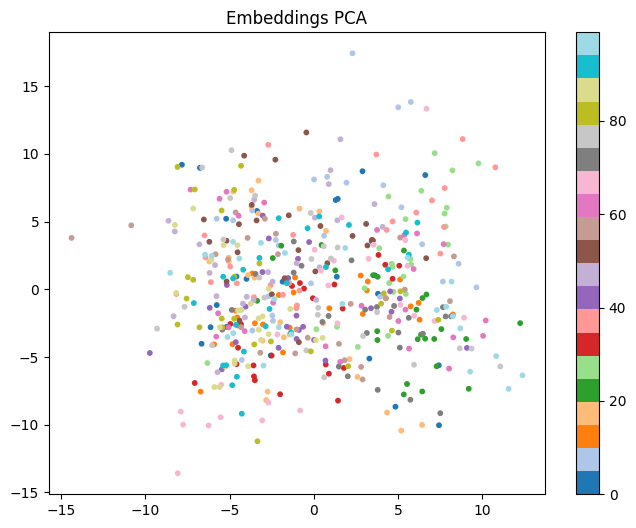

In [38]:
#тут прорил основные компоненты, не особо полезное представление
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_2d = PCA(n_components=2).fit_transform(X_val)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_val, cmap='tab20', s=10)
plt.title("Embeddings PCA")
plt.colorbar()
plt.show()